# Across scenario basic analysis

### Load packages

In [1]:
import os
import sys
import urllib, io
os.getcwd()
sys.path.append("..")
sys.path.append("../utils")
sys.path.append("../analysis/utils")


import numpy as np
import scipy.stats as stats
import pandas as pd

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

from tqdm.notebook import tqdm

import  matplotlib
from matplotlib import pylab, mlab, pyplot
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.style.use('seaborn-white')

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')
%matplotlib inline

import scipy.stats
import random

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [2]:
#display all columns
pd.set_option('display.max_columns', None)

## Theming

In [3]:
sns.set_style("white")

### Helper functions

In [4]:
#helper function for pd.agg
def item(x):
    """Returns representative single item"""
    return x.tail(1).item()

### Set up directory paths to plots and data

In [5]:
## directory & file hierarchy
proj_dir = os.path.abspath('..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir =  os.path.abspath('.')
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'behavioral_experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       
    
## add helpers to python path
if os.path.join(proj_dir,'utils') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'utils'))   

def make_dir_if_not_exists(dir_name):   
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    return dir_name

## create directories that don't already exist        
result = [make_dir_if_not_exists(x) for x in [results_dir,plot_dir,csv_dir]]

## Load in data

Assumes exported csvs from `basic_analysis.ipynb` in results folder

In [6]:
studies = [
    "drop_pilot",
    "collision_pilot",
    "rollingsliding_pilot",
    "dominoes_pilot",
    "clothiness_pilot",
    "towers_pilot",
    "linking_pilot",
    "containment_pilot",
]

In [22]:
ls `echo $csv_dir/'humans'`

human_accuracy-clothiness_pilot-production_2_testing.csv
human_accuracy-collision_pilot-production_2_testing.csv
human_accuracy-containment_pilot-production_2_testing.csv
human_accuracy-dominoes_pilot-production_1_testing.csv
human_accuracy-drop_pilot-production_2_testing.csv
human_accuracy-linking_pilot-production_2_testing.csv
human_accuracy-rollingsliding_pilot-production_2_testing.csv
human_accuracy-towers_pilot-production_2_testing.csv
human_responses-clothiness_pilot-production_2_testing.csv
human_responses-collision_pilot-production_2_testing.csv
human_responses-containment_pilot-production_2_testing.csv
human_responses-dominoes_pilot-production_1_testing.csv
human_responses-drop_pilot-production_2_testing.csv
human_responses-linking_pilot-production_2_testing.csv
human_responses-rollingsliding_pilot-production_2_testing.csv
human_responses-towers_pilot-production_2_testing.csv


In [45]:
#load all experiments as one dataframe
prefix = "human_responses-"
suffix = lambda s: "-production_%d_testing" % (1 if 'dominoes' in s else 2)
make_fname = lambda s: prefix + s + suffix(s) + ".csv"
df = []
for l in studies:
    _df = pd.read_csv(os.path.join(csv_dir, 'humans', make_fname(l)))
    if 'study' not in _df.columns:
        _df = _df.assign(study=[l] * len(_df), axis=0)
    df.append(_df)
df = pd.concat(df)
# df = pd.concat([pd.read_csv(os.path.join(csv_dir, 'humans', make_fname(l))) for l in studies])
print("Loaded dataframes")

Loaded dataframes


In [46]:
df['study']

0               drop_pilot
1               drop_pilot
2               drop_pilot
3               drop_pilot
4               drop_pilot
               ...        
15145    containment_pilot
15146    containment_pilot
15147    containment_pilot
15148    containment_pilot
15149    containment_pilot
Name: study, Length: 120450, dtype: object

In [47]:
#save nice scenario name
df['scenario'] = df['study'].apply(lambda x: x.split('_')[0])

In [48]:
#sort by it
df.sort_values('scenario',inplace=True)

In [49]:
#subtract stimulus presentation time from reaction time
df['rt'] = df['rt'] - 2500

In [50]:
#drop reaction times longer than 10 seconds
df['rt'] = df['rt'].apply(lambda x: x if x < 10000 else np.nan)

In [51]:
def outcome_helper(correct,response):
    response = response == "YES"
    if correct and response: return "hit"
    if not correct and response: return "false_alarm"
    if correct and not response: return "correct_rejection"
    if not correct and not response: return "miss"

In [52]:
#encode response kind
df['outcome'] = [outcome_helper(correct, response) for correct, response in zip(df['correct'],df['response'])]

In [53]:
df['outcome'].value_counts()

hit                  46011
correct_rejection    43379
false_alarm          16846
miss                 14214
Name: outcome, dtype: int64

In [307]:
df['target_hit_zone_label'][0:1]

224    True
Name: target_hit_zone_label, dtype: bool

## Plots

### Per stimulus

In [54]:
df['response'] = df['response'] == "YES" #encode response as boolean

In [515]:
df['c'] = 1
df['num_distractors'] = df['distractors'].apply(lambda x: len(x))
df['num_occluders'] = df['occluders'].apply(lambda x: len(x))

In [516]:
df['num_distractors'][-3:]

10242     2
10254    26
7799      2
Name: num_distractors, dtype: int64

In [517]:
per_stim_agg = df.groupby('stim_ID').agg({
    'scenario' : lambda s: s.head(1),
    'correct' : lambda cs: np.mean([1 if c == True else 0 for c in cs]),
    'response' : 'mean',
    'c' : 'count',
    'stim_url' : lambda s: s.head(1),
    'hdf5_url' : lambda s: s.head(1),
    'map_url' : lambda s: s.head(1),
    'target_hit_zone_label': 'mean',
    'num_distractors': 'mean',
    'num_occluders': 'mean'
})
per_stim_agg.sort_values('scenario',inplace=True)

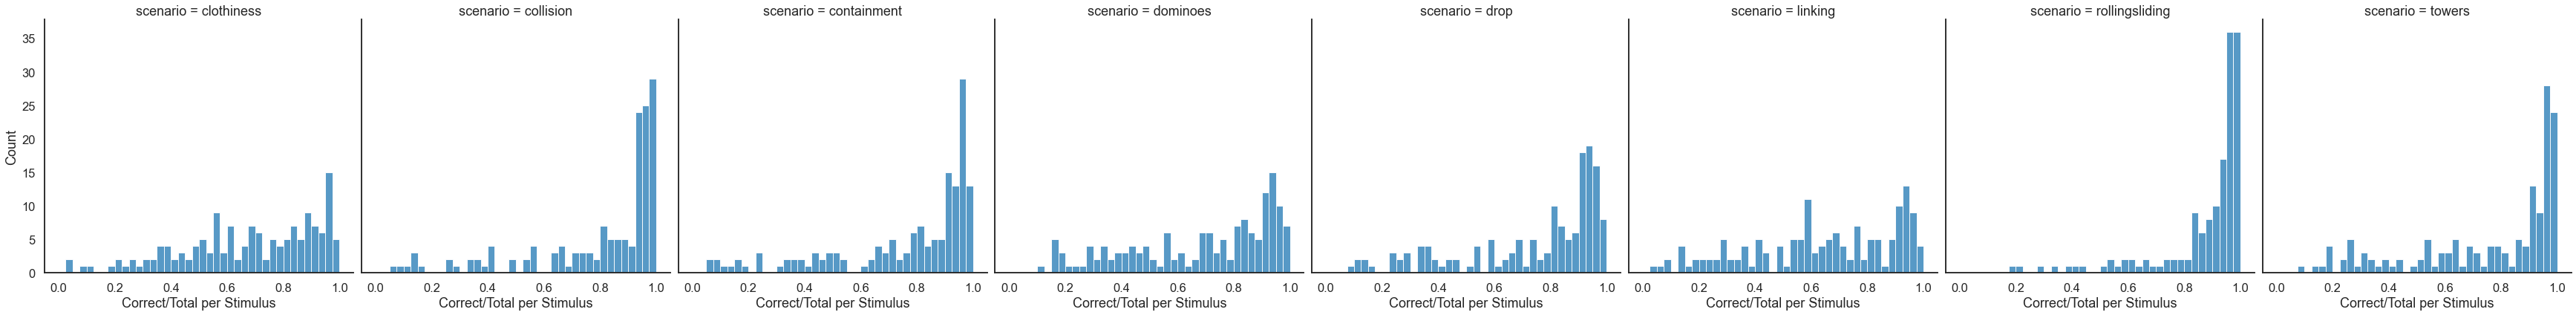

In [66]:
g = sns.FacetGrid(per_stim_agg, col="scenario", height=6)
g.map(sns.histplot, "correct", bins=40, binrange=[0,1])
g.set_axis_labels("Correct/Total per Stimulus","Count")
# g.savefig(os.path.join(plot_dir,"per_stim_16.pdf"))

Individual plots

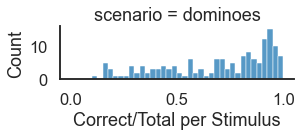

In [67]:
scenario = "dominoes"

g = sns.FacetGrid(per_stim_agg.query("scenario == @scenario"), col="scenario", height=2, aspect=2)
g.map(sns.histplot, "correct", bins=40, binrange=[0,1])
g.set_axis_labels("Correct/Total per Stimulus","Count")
# g.savefig(os.path.join(plot_dir,"per_stim_"+scenario+".pdf"))

In [68]:
per_stim_agg.query("scenario == @scenario")

,scenario,correct,response,c,stim_url
stim_ID,,,,,
pilot_dominoes_SJ020_d3chairs_o1plants_tdwroom_0029_img,dominoes,0.98,0.98,100,https://human-physics-benchmarking-dominoes-pi...
pilot_dominoes_2mid_J025R30_tdwroom_0007_img,dominoes,0.74,0.74,100,https://human-physics-benchmarking-dominoes-pi...
pilot_dominoes_2mid_J025R30_tdwroom_0008_img,dominoes,0.42,0.58,100,https://human-physics-benchmarking-dominoes-pi...
pilot_dominoes_2mid_J025R30_tdwroom_0012_img,dominoes,0.91,0.09,100,https://human-physics-benchmarking-dominoes-pi...
pilot_dominoes_2mid_J025R30_tdwroom_0014_img,dominoes,0.81,0.81,100,https://human-physics-benchmarking-dominoes-pi...
...,...,...,...,...,...
pilot_dominoes_1mid_J025R45_o1full_tdwroom_0023_img,dominoes,0.68,0.32,100,https://human-physics-benchmarking-dominoes-pi...
pilot_dominoes_1mid_J025R45_o1full_tdwroom_0024_img,dominoes,0.72,0.28,100,https://human-physics-benchmarking-dominoes-pi...
pilot_dominoes_1mid_J025R45_o1full_tdwroom_0025_img,dominoes,0.87,0.13,100,https://human-physics-benchmarking-dominoes-pi...


In [692]:
redyellow_filename("https://human-physics-benchmarking-towers-pilot.s3.amazonaws.com/pilot_towers_nb2_fr015_SJ010_mono0_dis0_occ0_boxroom-familiarization_0000_img.mp4")

pilot_towers_nb2_fr015_SJ010_mono0_dis0_occ0_boxroom-familiarization_0000_img.mp4


('https://human-physics-benchmarking-towers-redyellow-pilot.s3.amazonaws.com',
 'pilot_towers_nb2_fr015_SJ010_mono0_dis0_occ0_boxroom-familiarization-redyellow_0000_img.mp4')

In [699]:
import h5py
import cv2
from PIL import Image

def redyellow_filename(url):
    bucket, filename = str(url).split('https://')[-1].split('/')
    bucket = bucket.split('-')
    bucket.insert(-1, 'redyellow')
    bucket = '-'.join(bucket)
    bucket = "https://" + bucket

    filename = filename.split('_0')
    filename.insert(1, '-redyellow')
    filename.insert(2, '_0')
    filename = ''.join(filename)
    
    redyellow_url = bucket + '/' + filename
    return redyellow_url

def download_stims(stims, suffix='mp4', redyellow=False):
    if suffix == 'mp4':
        key, _dir = 'stim_url', 'mp4s'
    elif suffix == 'hdf5':
        key, _dir = 'hdf5_url', 'hdf5s'
    elif suffix == 'map':
        key, _dir = 'map_url', 'maps'
    else:
        raise NotImplementedError(suffix)

    p = !pwd
    p = p[0]
    files = []
    for i in range(len(stims)):
        url = stims[key][i]
        url = redyellow_filename(url) if redyellow else url
        fname = url.split('/')[-1]
        outname = os.path.join(p, _dir, fname)
        if not os.path.exists(outname):
            !wget `echo $url` -O `echo $outname`
#         else:
#             print("%s already exists" % fname)
        files.append(outname)
    return files
    
def get_frame_mp4(fname, frame_num=0):
    assert fname[-4:] == '.mp4', fname
    cap = cv2.VideoCapture(fname)
    if (cap.isOpened() == False):
        print("Error opening video stream")
    
    count = -1
    frame = None
    while (cap.isOpened()):
        ret, frame = cap.read()
        if ret == True:
            count += 1            
            last_frame = frame
        else:
            break

        if count == frame_num:
            break
            
    frame = last_frame
    
    cap.release()
    cv2.destroyAllWindows()
    
    if frame is not None:
        frame = np.stack([frame[...,c] for c in [2,1,0]], -1)

    return frame

def get_frame_hdf5(fname, frame_num=0, imkey='_img'):
    
    assert fname [-5:] == '.hdf5', fname
    f = h5py.File(fname)
    frames = sorted(list(f['frames'].keys()))
    images = f['frames'][frames[frame_num]]['images']
    im = images[imkey]
    try:
        im = Image.open(io.BytesIO(im[:]))    
    except:
        im = np.array(im)
    f.close()
    return np.array(im)

def get_cue_map(stim, shape=[512,512]):
    maps = download_stims(stim, 'map')
    im = Image.open(maps[0]).getdata()
    return np.array(im).reshape(shape + [4])[...,0:3]

In [702]:
### plotting ###

def read_depth_im(depth, depth_max=10.0):
    '''convert a [H,W,3] uint8 to a [H,W] depth image'''
    assert depth.shape[-1] == 3, depth.shape
    H,W,C = depth.shape
    depth = np.split(depth, C, axis=-1)
    out = np.zeros([H,W], dtype=np.float32)
    for c,d in enumerate(depth):
        out += d[...,0] * (256 ** (C - 1 - c))
    out *= 100.1
    out /= 256**3
    
    mask = (out <= depth_max).astype(float)
    out = mask * out + depth_max * (1-mask)
    return out

def overlay_cue_map(cue, im):
    cue = cue[...,0:3]
    assert cue.shape == im.shape, (cue.shape, im.shape)
    mask = (cue.max(axis=-1, keepdims=True) > 0).astype(im.dtype)
    out = cue * mask + im * (1 - mask)
    return out

def get_movie_frames(stim, start_frame=0, end_frame=150, num_plots=6, from_hdf5=False, redyellow=False):
    '''Get evenly spaced frames from a stim'''
    if 'pandas' in str(type(stim[0:1])):        
        stim = download_stims(stim, 'hdf5' if from_hdf5 else 'mp4', redyellow=redyellow)[0]
    else:
        assert isinstance(stim, str), (stim, type(stim))
        assert ('.mp4' in stim) or ('.hdf5' in stim), stim
    _get_func = get_frame_hdf5 if from_hdf5 else get_frame_mp4
    fnums = [int(d) for d in np.linspace(start_frame, end_frame, num_plots)]
    frames = [_get_func(stim, frame_num=n) for n in fnums]
    return frames

def plot_movie(axes, stim, start_frame=0, end_frame=150, num_plots=6, from_hdf5=False, 
               overlay_cue=False, redyellow=False):
    if axes is None:
        fig, axes = plt.subplots(1,num_plots, figsize=(num_plots * 4, 4))
        
    frames = get_movie_frames(stim, start_frame, end_frame, num_plots, from_hdf5, redyellow)
    
    if start_frame == 0 and overlay_cue:
        cue = get_cue_map(stim, shape=list(frames[0].shape[:2]))
        frames[0] = overlay_cue_map(cue, frames[0])
    
    fnums = [int(d) for d in np.linspace(start_frame, end_frame, num_plots)]
    for i,fr in enumerate(frames):
        axes[i].imshow(fr)
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].set_title('T = %d' % fnums[i])
        
def plot_movies(stims, start_frame=0, end_frame=150, num_plots=6, from_hdf5=False, overlay_cue=False, 
                redyellow=False, savename=None):
    
    num_stims = len(stims)
    fig, axes = plt.subplots(num_stims, num_plots, figsize=(num_plots * 4, num_stims * 4), sharex=True, sharey=True)
    for row in range(num_stims):
        stim = stims[row:row+1]
        if num_stims > 1:
            ax = axes[row]
        else:
            ax = axes
        plot_movie(ax, stim, start_frame, end_frame, num_plots, from_hdf5, overlay_cue, redyellow)
        if row != 0:
            for col in range(num_plots):
                ax[col].set_title('')
        ax[0].set_ylabel(("label = %s" % stim['target_hit_zone_label'][0]) + "\n" + ("acc = %.3f" % stim['correct'][0]))
    if savename is not None:
        plt.savefig('../figures/' + savename)
    plt.show()

def plot_passes(stim, frame_num=0, passes=['_img', '_id', '_depth', '_normals', '_flow'], 
                depth_max=10.0, flow_scale_factor=10.0, redyellow=False, savename=None):
    if len(stim) > 1:
        stim = stim[0:1]
    if 'pandas' in str(type(stim[0:1])):        
        stim = download_stims(stim, 'hdf5', redyellow=redyellow)[0]
    else:
        assert isinstance(stim, str), (stim, type(stim))
        assert ('.hdf5' in stim), stim    
    
    ims = []
    for p in passes:
        im = get_frame_hdf5(stim, frame_num, imkey=p)
        if p == '_depth':
            im = read_depth_im(im, depth_max=depth_max)
        if p == '_flow':
            im = (im / 255.) * flow_scale_factor
        ims.append(im)
        
    fig, axes = plt.subplots(1, len(passes), figsize=(len(passes) * 4, 4), sharex=True, sharey=True)
    for i,im in enumerate(ims):
        axes[i].imshow(im)
        axes[i].set_title(passes[i][1:])
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        
    if savename is not None:
        plt.savefig('../figures/' + savename)        
        
    plt.show()
    
    return ims

def plot_stim_array(stims, frames=0, num_rows=2, savename=None):
    '''
    Plot an array of stimuli at frame(s)
    '''
    stims = download_stims(stims, 'mp4')
    N = len(stims)
    if isinstance(frames, int):
        frames = [frames] * N
        
    ims = []
    for i,stim in enumerate(stims):
        im = get_frame_mp4(stim, frame_num=frames[i])
        ims.append(im)
    
    num_cols = np.ceil(N / num_rows).astype(int)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(4*num_cols, 4*num_rows), sharex=True, sharey=True)
    if num_rows == 1:
        axes = [axes]
    
    for row in range(num_rows):
        for col in range(num_cols):
            ind = row*num_cols + col
            ax = axes[row][col]
            ax.imshow(ims[ind])
            ax.set_xticks([])
            ax.set_yticks([])
    
    if savename is not None:
        if not os.path.exists('../figures/' + savename):
            plt.savefig('../figures/' + savename)
        else:
            raise ValueError("%s already exists, choose a new name!" % savename)
        
    plt.show()



In [672]:
def select_scenario(data, scenario='towers', cond=None):
    c = data['scenario'] == scenario
    if cond is not None:
        c = cond & c
    return c

def select_by_performance(data, acc_min=0.5, acc_max=1.0, cond=None):
    c = (data['correct'] >= acc_min) & (data['correct'] <= acc_max)
    if cond is not None:
        c = cond & c
    return c

def remove_occluders(data, cond=None):
    c = data['num_occluders'] == 2
    if cond is not None:
        c = cond & c
    return c

def remove_distractors(data, cond=None):
    c = data['num_distractors'] == 2
    if cond is not None:
        c = cond & c
    return c

def select_by_label(data, label=True, cond=None):
    c = data['target_hit_zone_label'] == label
    if cond is not None:
        c = cond & c
    return c

def select_by_substring(data, name='tdwroom', cond=None):
    if name is None:
        return cond
    c = data['stim_url'].str.contains(name)
    if cond is not None:
        c = cond & c
    return c

stim_ID
test19_0019_img                                                           False
test13_0011_img                                                           False
test13_0010_img                                                           False
test13_0009_img                                                           False
test13_0007_img                                                           False
                                                                          ...  
pilot_towers_nb4_fr015_SJ000_gr015sph_mono1_dis0_occ0_tdwroom_0011_img    False
pilot_towers_nb4_fr015_SJ000_gr015sph_mono1_dis0_occ0_tdwroom_0010_img    False
pilot_towers_nb4_fr015_SJ000_gr015sph_mono1_dis0_occ0_tdwroom_0009_img    False
pilot_towers_nb4_fr015_SJ000_gr015sph_mono1_dis0_occ0_tdwroom_0006_img    False
pilot_towers_nb2_fr015_SJ010_mono0_dis0_occ0_tdwroom_0001_img              True
Length: 1200, dtype: bool
--2021-06-04 10:30:07--  https://human-physics-benchmarking-towers-redyellow-pilot.s3.

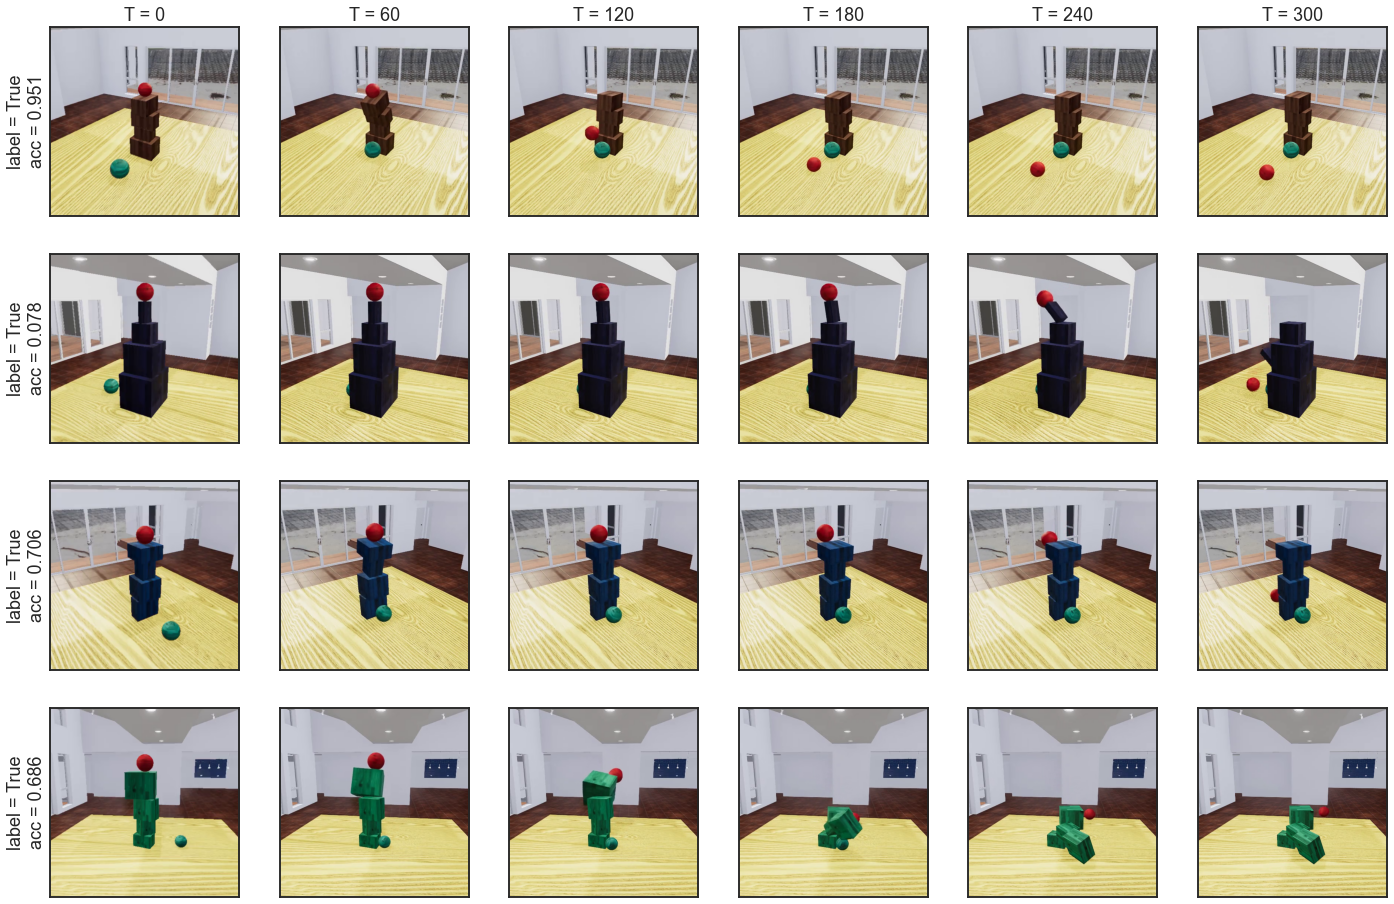

In [703]:
seed = 1
tower_cond = select_scenario(per_stim_agg, scenario='towers')
tower_cond = remove_occluders(per_stim_agg, tower_cond)
tower_cond = remove_distractors(per_stim_agg, tower_cond)
tower_cond = select_by_substring(per_stim_agg, name='tdwroom', cond=tower_cond)
tower_cond = select_by_label(per_stim_agg, True, tower_cond)
print(tower_cond)
# tower_cond = select_by_performance(per_stim_agg, acc_min=0.7, acc_max=0.9, cond=tower_cond)
tower_stims = per_stim_agg[tower_cond]
plot_movies(tower_stims.sample(4, random_state=seed), start_frame=0, end_frame=300, 
            overlay_cue=False,
            redyellow=True,
#             savename='example_towers.svg'
           )

In [645]:
tower_stims

,scenario,correct,response,c,stim_url,hdf5_url,map_url,target_hit_zone_label,num_distractors,num_occluders
stim_ID,,,,,,,,,,
pilot_towers_nb4_SJ025_mono1_dis0_occ0_tdwroom_0016_img,towers,0.754902,0.754902,102,https://human-physics-benchmarking-towers-pilo...,https://human-physics-benchmarking-towers-pilo...,https://human-physics-benchmarking-towers-pilo...,True,2,2
pilot_towers_nb4_SJ025_mono1_dis0_occ0_tdwroom_0004_img,towers,0.843137,0.156863,102,https://human-physics-benchmarking-towers-pilo...,https://human-physics-benchmarking-towers-pilo...,https://human-physics-benchmarking-towers-pilo...,False,2,2
pilot_towers_nb4_fr015_SJ000_gr-01_mono1_dis1_occ1_boxroom_0010_img,towers,0.764706,0.764706,102,https://human-physics-benchmarking-towers-pilo...,https://human-physics-benchmarking-towers-pilo...,https://human-physics-benchmarking-towers-pilo...,True,12,12
pilot_towers_nb4_SJ025_mono1_dis1_occ1_boxroom_0017_img,towers,0.784314,0.215686,102,https://human-physics-benchmarking-towers-pilo...,https://human-physics-benchmarking-towers-pilo...,https://human-physics-benchmarking-towers-pilo...,False,15,21
pilot_towers_nb4_SJ025_mono1_dis1_occ1_boxroom_0013_img,towers,0.852941,0.852941,102,https://human-physics-benchmarking-towers-pilo...,https://human-physics-benchmarking-towers-pilo...,https://human-physics-benchmarking-towers-pilo...,True,19,32
pilot_towers_nb2_fr015_SJ010_mono1_dis1_occ1_tdwroom_0011_img,towers,0.852941,0.852941,102,https://human-physics-benchmarking-towers-pilo...,https://human-physics-benchmarking-towers-pilo...,https://human-physics-benchmarking-towers-pilo...,True,12,26
pilot_towers_nb2_fr015_SJ010_mono1_dis1_occ1_tdwroom_0001_img,towers,0.823529,0.176471,102,https://human-physics-benchmarking-towers-pilo...,https://human-physics-benchmarking-towers-pilo...,https://human-physics-benchmarking-towers-pilo...,False,12,16
pilot_towers_nb3_fr015_SJ025_mono1_dis0_occ0_tdwroom_0007_img,towers,0.872549,0.127451,102,https://human-physics-benchmarking-towers-pilo...,https://human-physics-benchmarking-towers-pilo...,https://human-physics-benchmarking-towers-pilo...,False,2,2
pilot_towers_nb3_fr015_SJ025_mono1_dis0_occ0_tdwroom_0006_img,towers,0.823529,0.176471,102,https://human-physics-benchmarking-towers-pilo...,https://human-physics-benchmarking-towers-pilo...,https://human-physics-benchmarking-towers-pilo...,False,2,2


pilot_towers_nb4_fr015_SJ000_gr015sph_mono1_dis0_occ0_tdwroom_0018.hdf5 already exists


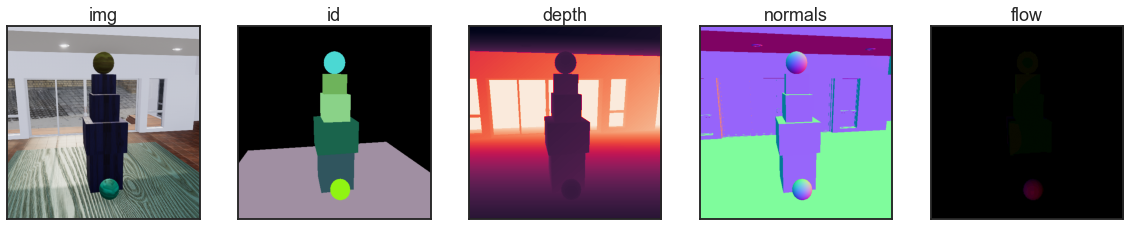

In [513]:
ims = plot_passes(easiest[-1:], frame_num=30, depth_max=10.0, flow_scale_factor=10)

## Get stims according to some condition from each scenario and plot it

In [633]:
scenarios = sorted(per_stim_agg['scenario'].unique())
seeds = {k:0 for k in scenarios}

clothiness 32
collision 19
containment 24
dominoes 37
drop 17
linking 28
rollingsliding 16
towers 17


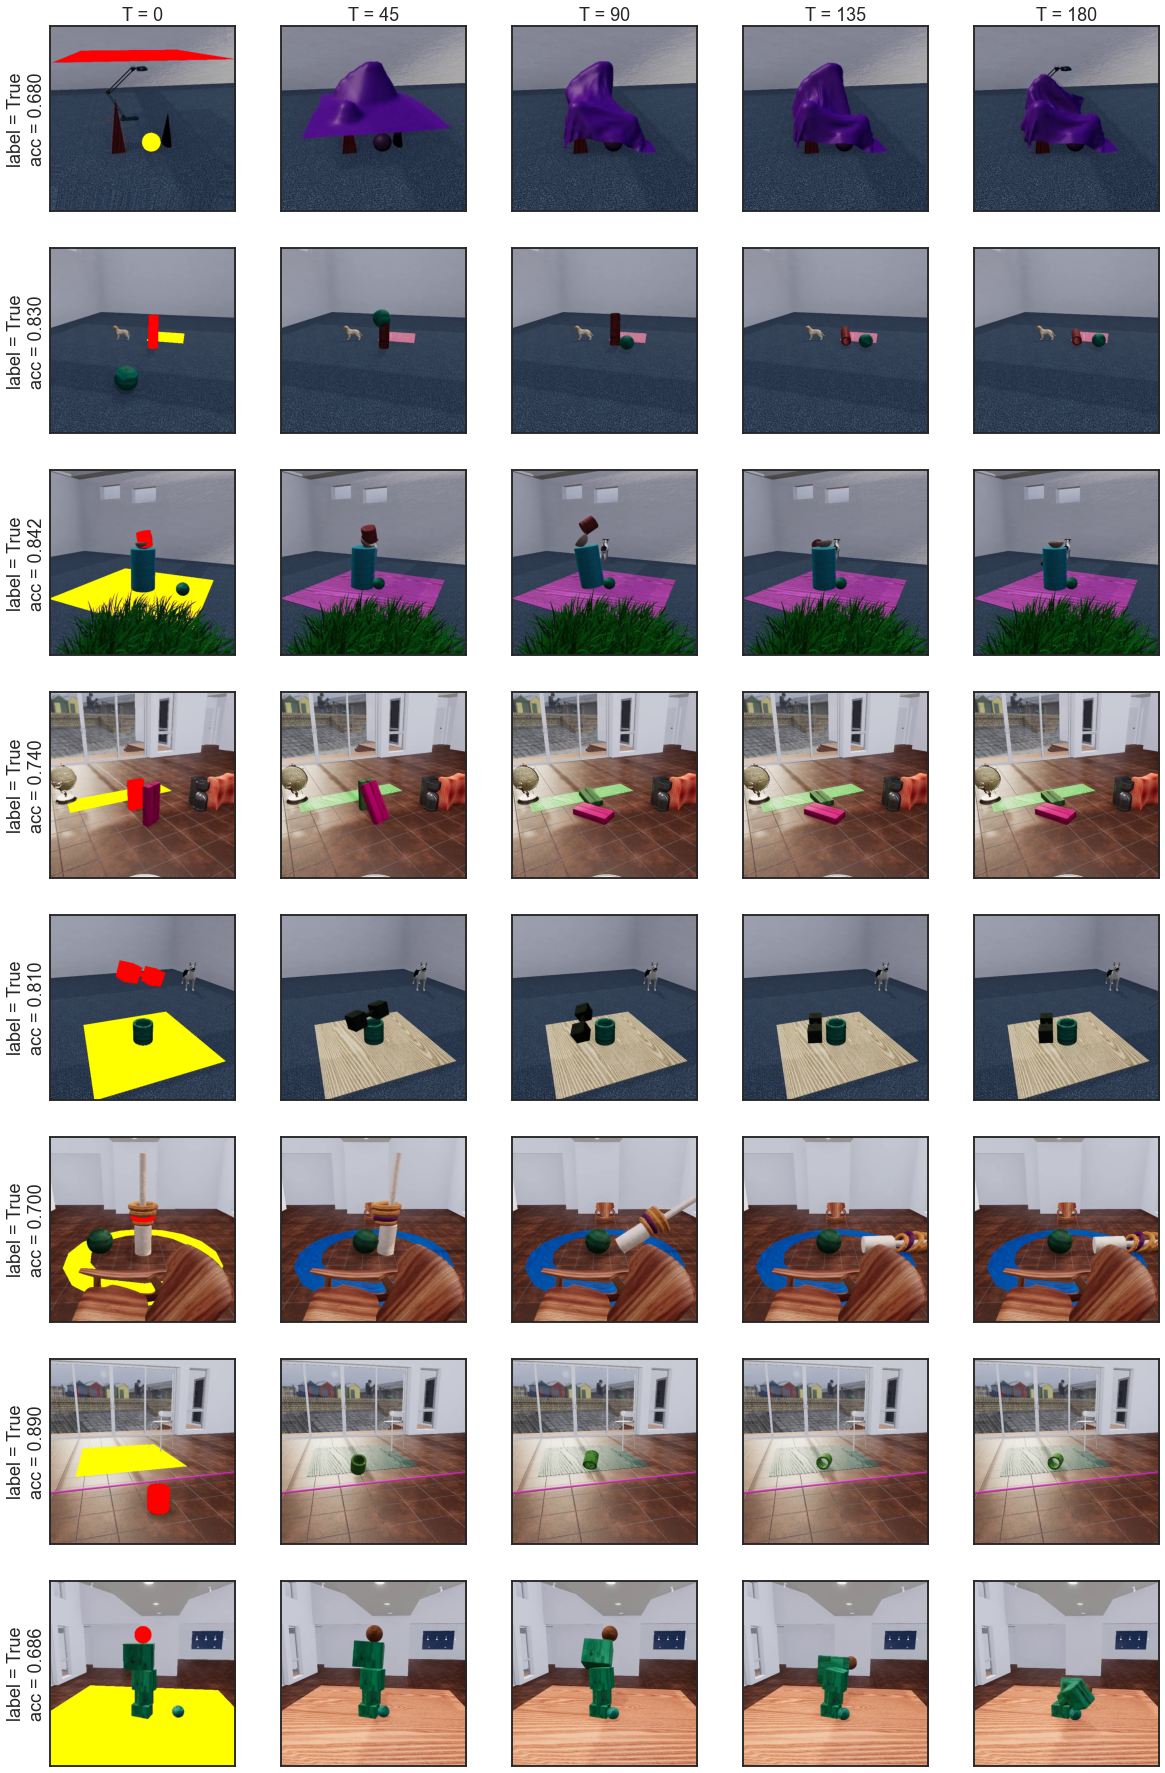

In [634]:
easiest = []
for scenario in scenarios:
#     cond = (per_stim_agg['scenario'] == scenario) & (per_stim_agg['num_occluders'] == 2)
    cond = per_stim_agg['scenario'] == scenario
    cond = cond & (per_stim_agg['target_hit_zone_label'] == True)
    cond = cond & (per_stim_agg['correct'] > 0.6) & (per_stim_agg['correct'] < 0.9)
    df_s = per_stim_agg[cond]
    n_selected = len(df_s)
    med = n_selected // 2
#     df_s = df_s.sort_values('correct')
    print(scenario, n_selected)
    df_s = df_s.sample(n=1, random_state=seeds[scenario])
    easiest.append(df_s)
easiest = pd.concat(easiest)
plot_movies(easiest, start_frame=0, end_frame=180, num_plots=5, overlay_cue=True,
           )
#             savename='hard_false_label_per_scenario.svg')

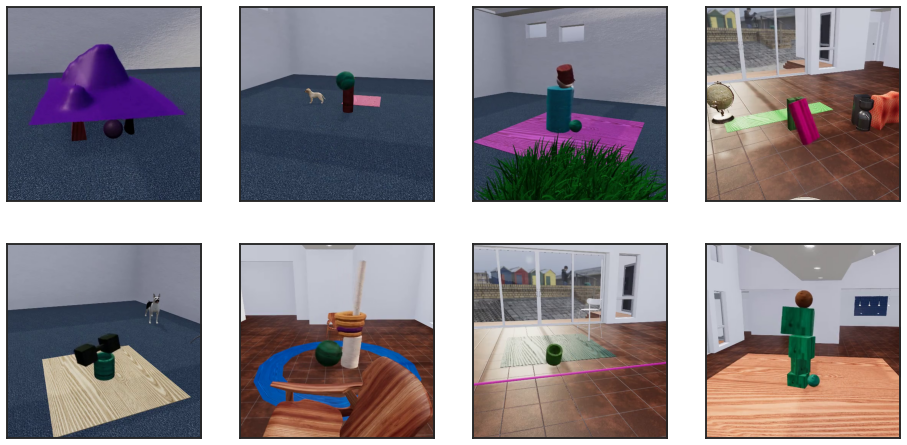

In [636]:
plot_stim_array(easiest, frames=45)

In [561]:
easiest

,scenario,correct,response,c,stim_url,hdf5_url,map_url,target_hit_zone_label,num_distractors,num_occluders
stim_ID,,,,,,,,,,
test13_0010_img,clothiness,0.710000,0.710000,100,https://human-physics-benchmarking-clothiness-...,https://human-physics-benchmarking-clothiness-...,https://human-physics-benchmarking-clothiness-...,True,2,2
pilot_it2_collision_simple_box_2_dis_2_occ_0005_img,collision,0.930000,0.930000,100,https://human-physics-benchmarking-collision-p...,https://human-physics-benchmarking-collision-p...,https://human-physics-benchmarking-collision-p...,True,37,44
pilot-containment-cone-plate_0016_img,containment,0.881188,0.881188,101,https://human-physics-benchmarking-containment...,https://human-physics-benchmarking-containment...,https://human-physics-benchmarking-containment...,True,21,27
pilot_dominoes_2mid_J025R30_tdwroom_0000_img,dominoes,0.770000,0.230000,100,https://human-physics-benchmarking-dominoes-pi...,https://human-physics-benchmarking-dominoes-pi...,https://human-physics-benchmarking-dominoes-pi...,False,2,2
pilot_it2_drop_all_bowls_tdw_1_dis_1_occ_0000_img,drop,0.840000,0.840000,100,https://human-physics-benchmarking-drop-pilot....,https://human-physics-benchmarking-drop-pilot....,https://human-physics-benchmarking-drop-pilot....,True,34,19
pilot_linking_nl1-6_ms03-7_aCylcap_bCyl_tdwroom_0014_img,linking,0.670000,0.670000,100,https://human-physics-benchmarking-linking-pil...,https://human-physics-benchmarking-linking-pil...,https://human-physics-benchmarking-linking-pil...,True,2,2
pilot_it2_rollingSliding_simple_ledge_box_2_dis_2_occ_0000_img,rollingsliding,0.950000,0.050000,100,https://human-physics-benchmarking-rollingslid...,https://human-physics-benchmarking-rollingslid...,https://human-physics-benchmarking-rollingslid...,False,50,37
pilot_towers_nb4_fr015_SJ000_gr015sph_mono1_dis0_occ0_tdwroom_0018_img,towers,0.892157,0.107843,102,https://human-physics-benchmarking-towers-pilo...,https://human-physics-benchmarking-towers-pilo...,https://human-physics-benchmarking-towers-pilo...,False,2,2
